<a href="https://colab.research.google.com/github/Asertigi/task_GAN/blob/main/task_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GAN (5 pts)

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
matplotlib.style.use('ggplot')

In [3]:
# learning parameters
batch_size = 512
epochs = 200
sample_size = 64 # fixed sample size
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = 'cpu'

In [4]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

In [5]:
train_data = datasets.MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 4.97MB/s]


Extracting ../input/data/MNIST/raw/train-images-idx3-ubyte.gz to ../input/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 161kB/s]


Extracting ../input/data/MNIST/raw/train-labels-idx1-ubyte.gz to ../input/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]


Extracting ../input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../input/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.01MB/s]

Extracting ../input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../input/data/MNIST/raw



In [6]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(nz, 256),
            nn.ReLU(True),

            nn.Linear(256, 512),
            nn.ReLU(True),

            nn.Linear(512, 1024),
            nn.ReLU(True),

            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [8]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)

In [9]:
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [10]:
criterion = nn.BCELoss()

In [11]:
losses_g = []
losses_d = []
images = []

In [12]:
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

In [13]:
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [14]:
def save_generator_image(image, path):
    save_image(image, path)

In [15]:
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [16]:
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [17]:
noise = create_noise(sample_size, nz)
generator.train()
discriminator.train()

Discriminator(
  (main): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=1024, bias=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=512, out_features=256, bias=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Linear(in_features=256, out_features=1, bias=True)
    (8): Sigmoid()
  )
)

Epoch 199 of 200
Generator loss: 3.03774905, Discriminator loss: 0.41849989


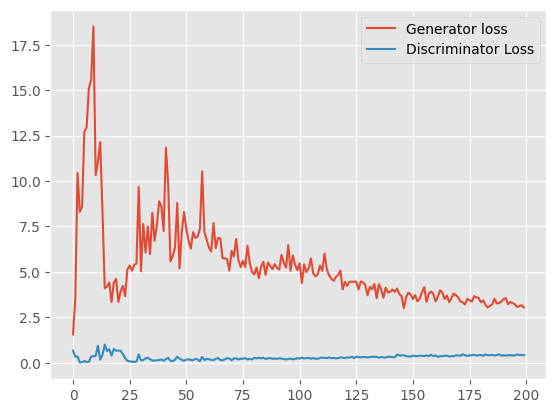

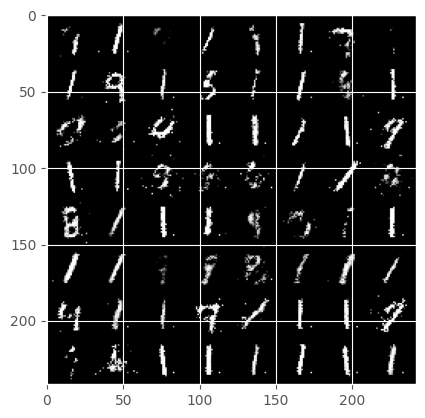

In [18]:
from IPython.display import clear_output
losses_g=[]
losses_d=[]
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # run the discriminator for k number of steps
        for step in range(k):
            data_fake = generator(create_noise(b_size, nz)).detach()
            data_real = image
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    # make the images as grid
    generated_img = make_grid(generated_img)

    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g.detach().numpy())
    losses_d.append(epoch_loss_d.detach().numpy())
    clear_output(wait=True)
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")
    plt.figure()
    plt.plot(np.array(losses_g), label='Generator loss')
    plt.plot(np.array(losses_d), label='Discriminator Loss')
    plt.legend()
    plt.show()

    plt.imshow(generated_img.permute(1, 2, 0))
    plt.show()

Я видимо совсем не понял как делать этот таск, но вы сами говоирили, что ГАНы это не лучший способ) хотя может тут я налажал. Прикрепляю одну из лучших свои попыток: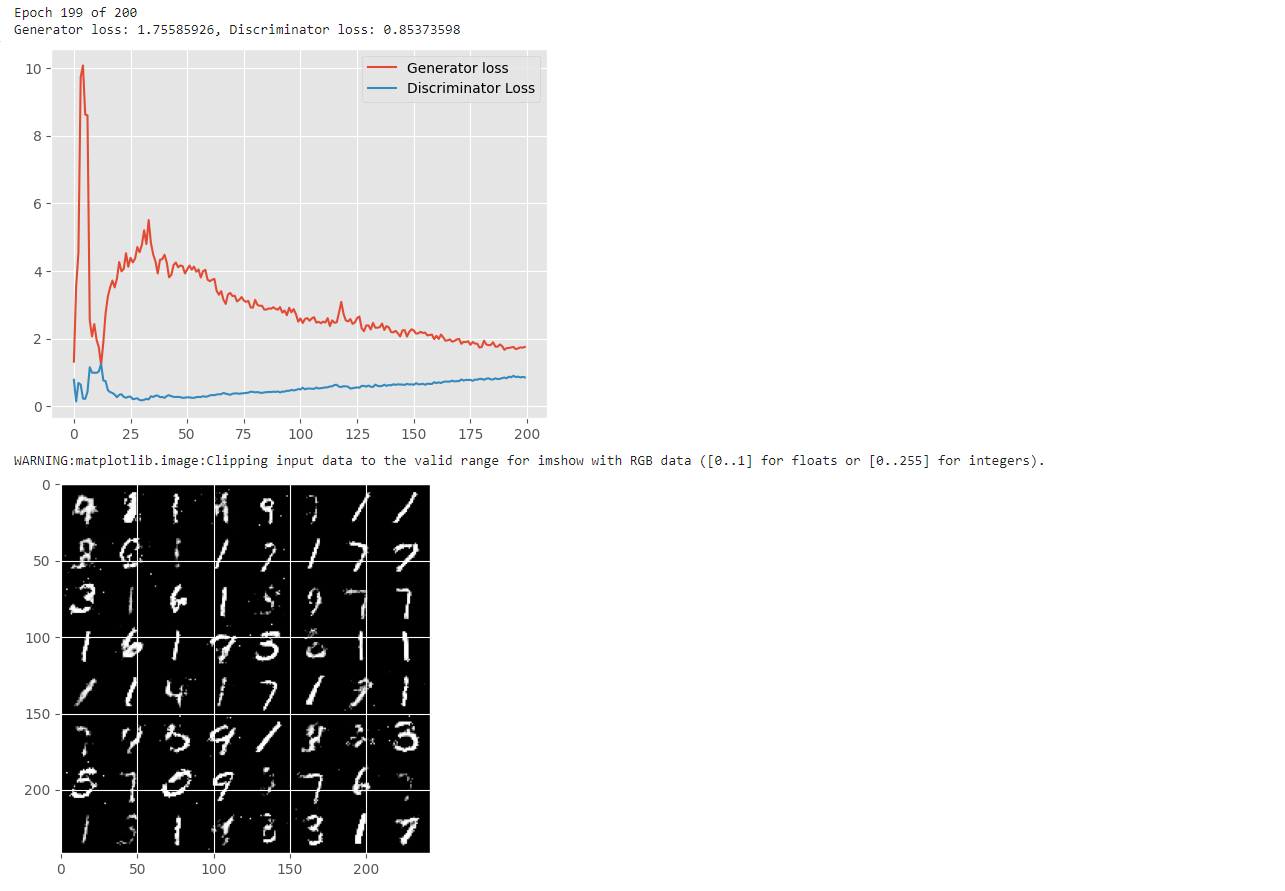